# Xi0Stat Tutorial

## Setup

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.cosmology import FlatLambdaCDM

In [3]:
%cd ../

/Users/af/Work/Cosmo/codes/Xi0Stat


In [4]:
from Xi0Stat.globals import * 
from Xi0Stat.GW import get_all_events
from Xi0Stat.GLADE import GLADE
from Xi0Stat.GWENS import GWENS
from Xi0Stat.SYNTH import SYNTH
from Xi0Stat.completeness import *
from Xi0Stat.galCat import GalCompleted
from Xi0Stat.GWgal import GWgal
from Xi0Stat.betaHom import BetaHom

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## GW

This module is based on the object Skymap3D. This contains the GW skymap for a single GW event denoted by its name - a string accessible by the attribute self.event_name. E.g.: 'GW170817'
Main attributes:
- npix: N of pixels
- nside : skymap nside
- pixarea: area of a pixel in rad^2
- p: probability in a pixel (the rho of Singer et al.)
- mu, sigma, norm: mu, sigma, N of the skymap 
- metadata: the metadata of the event. The metadata file should be a .csv file in the folder data/GW/metadata (editable in globals/metaPath). For O2, it should be called GWTC-1-confident.csv . The file in csv is downloadable at https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/

Key methods to compute likelihood:

- likelihood(self, r, theta, phi) : likelihood given GW lum distance r, and polar angles theta, phi in radians 
- likelihood_px(self, r, pix) : lileihood  given GW lum distance r and pixel

(Note that the likelihood is a Gaussian truncated at zero. )

- likelihood_in_credible_region(self, r, level=0.99,) : likelihood in all the pixels of the credible region specified by level at given GW lum disance r
- d_max(self, SNR_ref=8): Max GW luminosity distance at which the evend could be seen, assuming its SNR and a threshold SNR_ref:d_max = d_obs*SNR/SNR_ref
- get_zlims(self, H0max=220, H0min=20, Xi0max=3, Xi0min=0.2) : Computes the possible range in redshift for the event given the prior range for H0 and XI0



Other: the module contains the function get_all_events(loc='data/GW/O2/', subset, subset_names) , that reads all the skymaps in the folder specified by loc and returns a dictionary {event name: Skymap3D}

If subset=True, the dictionary will contain only the events specified in subset_names, which should be a list of names, e.g. : get_all_events(loc='data/GW/O2/', subset=True, subset_names=['GW170817',]) to return skymap of GW170817

In [97]:
# Example: load skymaps of O2 events GW170817 

#O2 = get_all_events(loc='data/GW/O2/', subset=True, subset_names=['GW170817',])
O2 = get_all_events(loc='data/GW/O2/', level=0.99)

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [98]:
O2.keys()

dict_keys(['GW170817', 'GW150914'])

In [99]:
# Example: chech area of the 90% credible region of GW170817

O2['GW170817'].area(level=0.9)

16.15640267031496

## Completeness

In [115]:
compl = SkipCompleteness()

compl = MaskCompleteness(comovingDensityGoal=0.1, nMasks=5, zRes=90)

compl = SuperpixelCompleteness(comovingDensityGoal=0.1, angularRes=4, interpolateOmega=False, zRes=90)

## GLADE

In [116]:
# uncomment to compute posteriors and save. then put file into GLADE folder, comment, and proceed. 

#glade = GLADE('GLADE', compl, useDirac=False, computePosterior=True, verbose=True)
#glade.data.to_csv('posteriorglade.csv', index=False)  

glade = GLADE('GLADE', compl, useDirac=False, finalData='posteriorglade.csv', verbose=True)


Directly loading final data posteriorglade.csv
Computing completeness
Computing in parallel... 
 Almost done!
Final computations for completeness...
Done.


## Completeness and GW events

(34.20163682429269, 10.623127422434493, 57.78014622615089, 7.85950313395273)


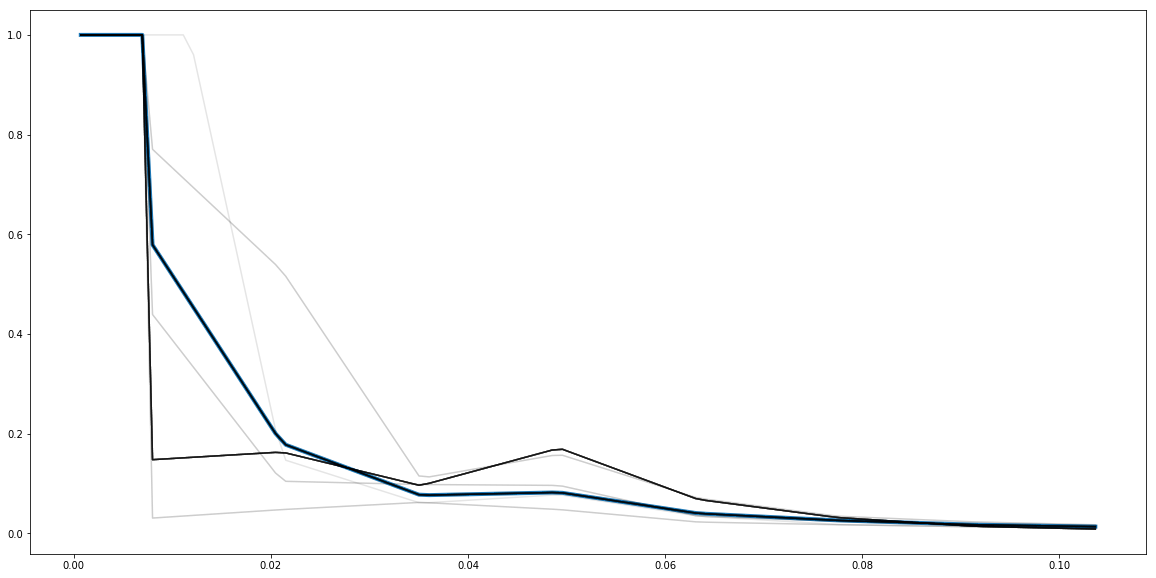

(383.7723827769709, 153.92692935990763, 613.6178361940342, 76.6151511390211)


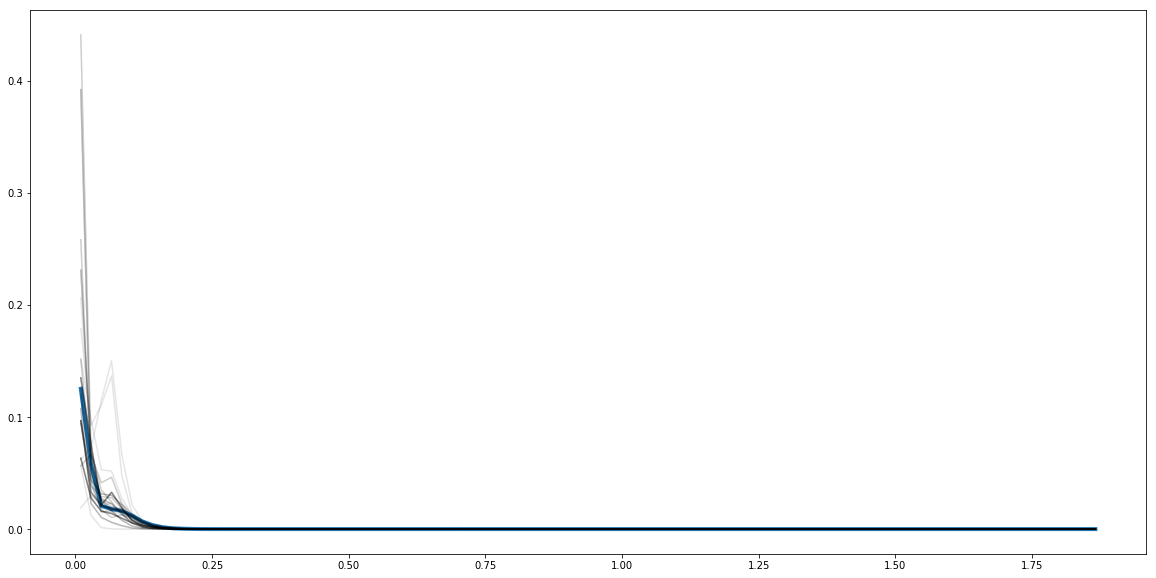

In [134]:
for key, ev in O2.items():
    plt.figure(figsize=(20,10))
    print(ev.find_r_loc())
    zmin, zmax = ev.get_z_lims()
    z = np.linspace(zmin, zmax, 100)
    
    c = glade.completeness(*ev.find_event_coords(polarCoords=True), z)
    plt.plot(z, c, linewidth=4)
    #plt.show()
   
    theta, phi, _ = ev.sample_posterior(nSamples=50)
    c = glade.completeness(theta, phi, z)
    plt.plot(z, c.T, c='k', alpha=0.1)
    #plt.ylim([0,1])
    plt.show()

In [135]:
gals = GalCompleted()
#gals = GalCompleted(completionType='mult')
#gals = GalCompleted(completionType='add')
gals.add_cat(glade)

## GWgal

This module contains the object GWgal. Its main attributes are :
- gals : a GalCompleted object
- GWevents: a dictionary {event name: Skymap3D} for the GW events

At initialization, two other attributes will be created:
- cred_pixels : a dictionary {event name: list of pixels of the credible region specified by credible_level (default 0.99)}
- z_lims : a dictionary {event name: (z_min, z_max) } where z_min, z_max are the min and max redshift for all prior ranges in H0 and Xi0 . This is computed using mean+-3sigma with mean and sigma the mu and std of the GW luminosity distance, taken from the header of the skymap 

In [136]:
myGWgal = GWgal(gals, O2)

## Computing posterior

In [ ]:
# Compute likelihood for H0 on a grid
H0grid = np.linspace(20, 300, 40)
Xi0grid = np.linspace(1,1,1)
myGWgal._galRedshiftErrors = True


liks = myGWgal.get_lik(H0s=H0grid, Xi0s=Xi0grid, n=1.91)



Restricting area of the catalogue to 10104 pixels with nside=1024
2076 galaxies kept
Setting z range of the catalogue between 0.0007064068352748932, 0.10368770946539926
1416 galaxies kept
Restricting area of the catalogue to 38544 pixels with nside=512
14741 galaxies kept
Setting z range of the catalogue between 0.009827796600162923, 1.8659850273088918
14659 galaxies kept


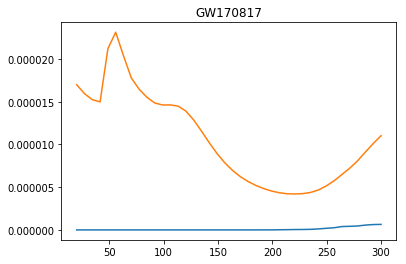

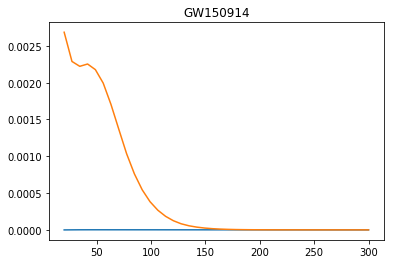

In [91]:

lik_inhom = np.squeeze(np.ones((H0grid.size, Xi0grid.size)))
lik_hom = np.squeeze(np.ones((H0grid.size, Xi0grid.size)))

for key, val in liks.items():
    
   # plt.plot(H0grid, val[0]/H0grid**2)
    plt.plot(H0grid, val[1]/H0grid**3)
    plt.plot(H0grid, (val[0]+val[1])/H0grid**3)
    plt.title(key)
    plt.show()
    
    
    lik_inhom *= val[0] 
    lik_hom *= val[1] 
    
    

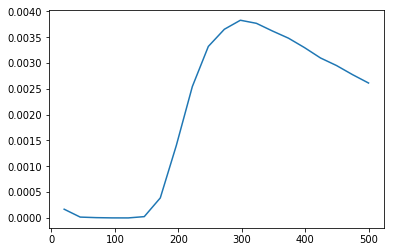

In [233]:
# # Plot the posterior with beta=H0^3
# plt.imshow(lik, extent=[Xi0grid[0],Xi0grid[-1],H0grid[0],H0grid[-1]])
# plt.colorbar()


# plt.show()


# norm=np.trapz(lik[:,0]/H0grid**3, H0grid)
# plt.plot(H0grid, lik[:,0]/H0grid**3/norm)
# plt.show()

norm=np.trapz((lik_hom+lik_inhom)/H0grid**6, H0grid)
plt.plot(H0grid, (lik_hom+lik_inhom)/H0grid**6/norm)
plt.show()

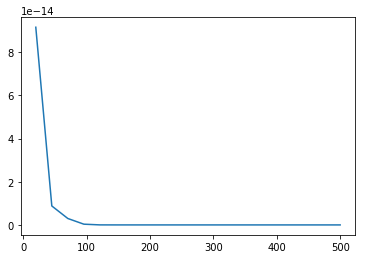

In [231]:
plt.plot(H0grid[:], lik_inhom[:]/H0grid[:]**6)

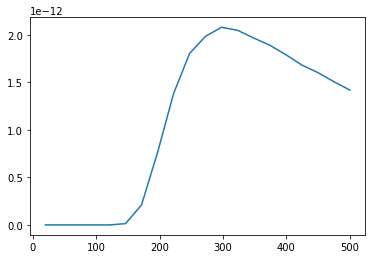

In [232]:
plt.plot(H0grid[:], lik_hom[:]/H0grid[:]**6)